In [1]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append("/Users/ryan/Desktop/work/school intern/Energy Intern /eco-tools/") #path to PI CLient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import requests
import seaborn as sns 
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
#print(mnv.version)  # Last updated for mnv v2.0.1
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
pc = pi_client(root='readonly') #assgin values
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu") #GBSF_ChilledWater_Demand_kBtu
start = "2017-07-05" 
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points,  start = start, 
                            end = end,calculation=calculation,
                            interval=interval)
df = df[np.isfinite(df).all(1)]

Grabbing WebIDs ...
WebID collection complete!
14:23:25: Sending API request... Chunk 1 of 1
14:23:26: Response recieved for 1 tags! (0.99)


# 3sd method

In [22]:
def sd_detect(dataframe, threshold=3):
    dataframe = pd.DataFrame(dataframe)
    mean_1 = dataframe.mean()[0]
    std_1 = dataframe.std()[0]
    dataframe['zscore'] = (dataframe.values - mean_1)/std_1
    dataframe['outlier'] = np.nan
    dataframe.loc[(np.abs(dataframe.zscore) > threshold), 'outlier'] = dataframe.iloc[:,0].loc[(np.abs(dataframe.zscore) > threshold)]
    dataframe.drop(columns='zscore', inplace=True)
    return dataframe


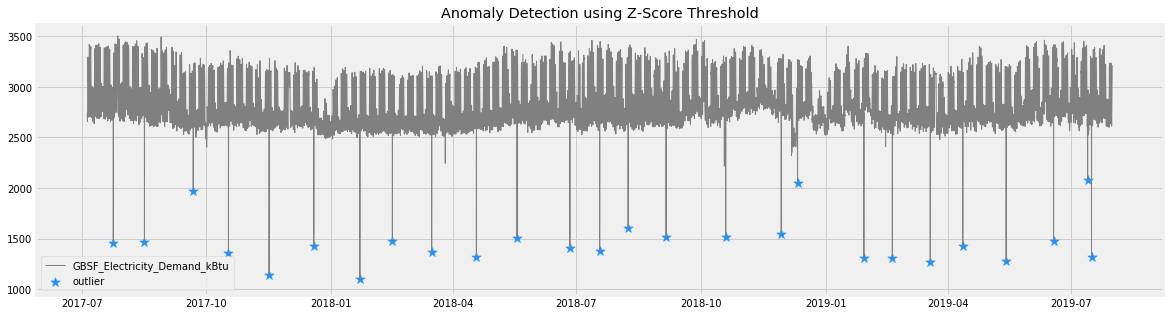

In [23]:
outlier_datapoints = sd_detect(df.GBSF_Electricity_Demand_kBtu)
# plot size 
plt.figure(figsize=(18,5))
# plot all electricity data, linewidth = 1, color = gray
plt.plot(outlier_datapoints.index, outlier_datapoints.GBSF_Electricity_Demand_kBtu,
        linewidth=1, color='gray')
# plot outliers data, them must have the same index to plot sucessfully, color = blue, maker = *, size = 100
plt.scatter(outlier_datapoints.index, outlier_datapoints.outlier, color='dodgerblue', marker='*', s=100)
plt.title("Anomaly Detection using Z-Score Threshold")
# set up at the leftbottom 
plt.legend()
plt.show()

# 25th and 75th Percentile method

In [20]:
def percentile_detect(df):
    a = df.iloc[:,0]
    q1 = np.percentile(a,25)
    q3 = np.percentile(a,75)
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr)
    upper_bound = q3 +(1.5 * iqr) 
    print("lower_bound: %f" %lower_bound,"and","upper_bound: %f" %upper_bound)
    
    b = (a<lower_bound) | (a>upper_bound)
    df['outlier'] = np.nan
    residual_outliers = a.loc[b]

    #newdf = pd.concat([df, residual_outliers], axis =1)
    new_residual_outliers = residual_outliers.values.tolist()
    df.loc[((a<lower_bound) | (a>upper_bound)), 'outlier'] = df.iloc[:,0].loc[(a<lower_bound) | (a>upper_bound)]
    return df     


lower_bound: 2105.373260 and upper_bound: 3583.364016


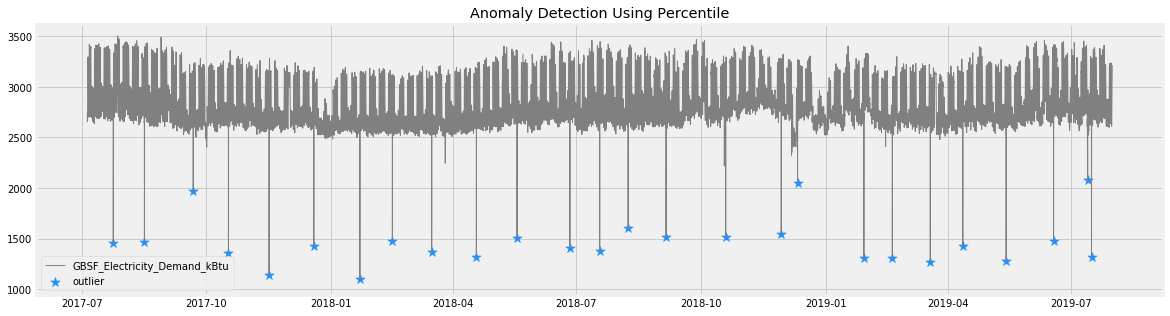

In [21]:
#plt.plot(df.outlier)
outlier_datapoints = percentile_detect(df)
# plot size 
plt.figure(figsize=(18,5))
# plot all electricity data, linewidth = 1, color = gray
plt.plot(outlier_datapoints.index, outlier_datapoints.GBSF_Electricity_Demand_kBtu,
        linewidth=1, color='gray')
# plot outliers data, them must have the same index to plot sucessfully, color = blue, maker = *, size = 100
plt.scatter(outlier_datapoints.index, outlier_datapoints.outlier, color='dodgerblue', marker='*', s=100)
plt.title("Anomaly Detection Using Percentile")
# set up at the leftbottom 
plt.legend()
plt.show()